In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization
from tensorflow.keras.regularizers import l2

from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [5]:
titanic_data = pd.read_csv(r"https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data Preprocessing

#### Filling Missing Values

In [3]:
titanic_data.isnull().sum().loc[lambda x:x>0]

Age         177
Cabin       687
Embarked      2
dtype: int64

In [4]:
titanic_data['Age'].fillna(titanic_data['Age'].median(), inplace=True)

C:\Users\419007\AppData\Local\Temp\ipykernel_9112\2129876400.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data['Age'].fillna(titanic_data['Age'].median(), inplace=True)


In [5]:
titanic_data['Cabin'].fillna(titanic_data['Cabin'].mode()[0], inplace=True)

C:\Users\419007\AppData\Local\Temp\ipykernel_9112\2579435079.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data['Cabin'].fillna(titanic_data['Cabin'].mode()[0], inplace=True)


In [6]:
titanic_data['Embarked'].fillna(titanic_data['Embarked'].mode()[0], inplace=True)

C:\Users\419007\AppData\Local\Temp\ipykernel_9112\3993763136.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data['Embarked'].fillna(titanic_data['Embarked'].mode()[0], inplace=True)


In [8]:
titanic_data.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

### Checking data

In [9]:
titanic_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
titanic_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [11]:
#From the very first view we can identify that some columns are irrelavant for the predcition of survived class like PassengerID,Name,Ticket,Cabin
#Sex is not directly impacted,but the women and children first policy may be impacted.
titanic_data = titanic_data.drop(columns=['PassengerId','Name','Ticket','Cabin'])


In [12]:
titanic_data.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

In [13]:
#Sex and embarked are object columns i should change the datatype into numerical. 
#Label encoding for sex
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
titanic_data['Sex'] = label_encoder.fit_transform(titanic_data['Sex'])

In [14]:
#One hot encoding for Embarked column
titanic_data = pd.get_dummies(titanic_data, columns=['Embarked'])

In [17]:
# Convert boolean columns to numeric
titanic_data['Embarked_Q'] =titanic_data['Embarked_Q'].astype(int)
titanic_data['Embarked_S'] = titanic_data['Embarked_S'].astype(int)
titanic_data['Embarked_C'] = titanic_data['Embarked_C'].astype(int)

In [ ]:
titanic_data.dtypes#Converted to numerical

Survived        int64
Pclass          int64
Sex             int32
Age           float64
SibSp           int64
Parch           int64
Fare          float64
Embarked_C      int32
Embarked_Q      int32
Embarked_S      int32
dtype: object

In [19]:
titanic_data.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [20]:
from sklearn.ensemble import RandomForestClassifier

# Features and target variable
X = titanic_data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked_C', 'Embarked_Q', 'Embarked_S']]
y = titanic_data['Survived']

# Train the model
model = RandomForestClassifier()
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_
feature_importance = pd.Series(importances, index=X.columns)
print(feature_importance)

Pclass        0.083277
Sex           0.270423
Age           0.254886
SibSp         0.048461
Parch         0.038353
Fare          0.271003
Embarked_C    0.012324
Embarked_Q    0.007400
Embarked_S    0.013872
dtype: float64


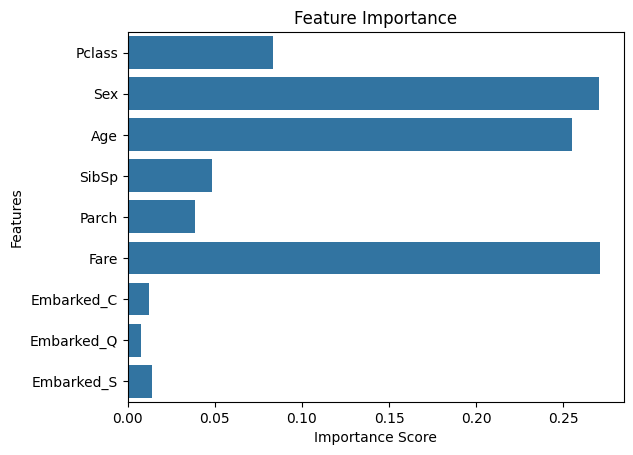

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
# Plot feature importances
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=0.2)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((757, 9), (134, 9), (757,), (134,))

In [24]:
# Standardize the features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
# # Define the neural network architecture
# model = Sequential()
# model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(16, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Define the neural network architecture
model = Sequential()
model.add(Dense(128, input_dim=x_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5)) 
model.add(Dense(1, activation='sigmoid'))

In [28]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
ROP=ReduceLROnPlateau(MONITOR='val_loss',factor=0.5,patience=5)

In [30]:
model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5046 - loss: 1.1185 - val_accuracy: 0.7961 - val_loss: 0.6366
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5783 - loss: 0.8767 - val_accuracy: 0.8224 - val_loss: 0.5917
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6145 - loss: 0.8252 - val_accuracy: 0.8421 - val_loss: 0.5627
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6576 - loss: 0.7542 - val_accuracy: 0.8553 - val_loss: 0.5459
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6553 - loss: 0.6805 - val_accuracy: 0.8421 - val_loss: 0.5325
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6688 - loss: 0.7145 - val_accuracy: 0.8421 - val_loss: 0.5159
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7126 - loss: 0.6379 - val_accuracy: 0.8487 - val_loss: 0.5022
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7192 - loss: 0.6641 - val_accuracy: 0.8421 - val_loss:

In [31]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {accuracy}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.8434 - loss: 0.4055  
Test Accuracy: 0.8283582329750061


In [33]:
# Predict on the test set
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Accuracy: 0.8283582089552238
Precision: 0.8235294117647058
Recall: 0.75
F1 Score: 0.7850467289719626


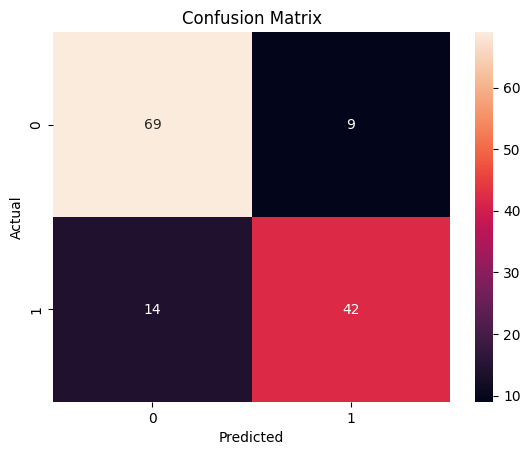

In [34]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

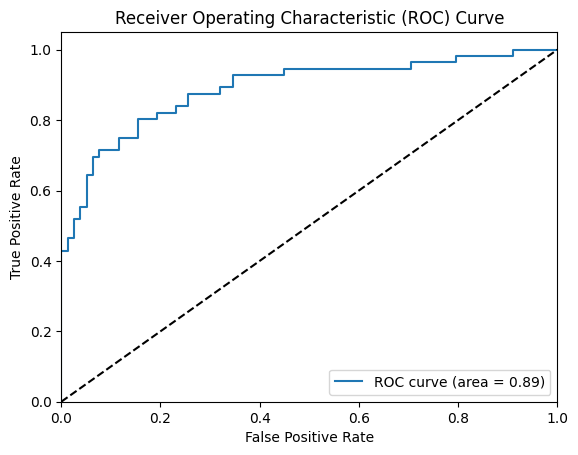

In [35]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test.values.ravel(), y_pred_prob.ravel())
roc_auc = auc(fpr,tpr)

plt.figure()
plt.plot(fpr,tpr,label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0.0 ,1.0])
plt.ylim([0.0 ,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### After Data Balanced using smote

In [36]:
from collections import Counter
from imblearn.over_sampling import SMOTE
sm=SMOTE()
x_data,y_data=sm.fit_resample(X,y)
print(Counter(y_data))

Counter({0: 549, 1: 549})


In [37]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x_data,y_data,random_state=42,test_size=0.15)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((933, 9), (165, 9), (933,), (165,))

In [38]:
# Standardize the features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [39]:
# Define the neural network architecture
model = Sequential()
model.add(Dense(128, input_dim=x_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5)) 
model.add(Dense(1, activation='sigmoid'))

c:\Users\419007\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [40]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [41]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
ROP=ReduceLROnPlateau(MONITOR='val_loss',factor=0.5,patience=5)

In [42]:
model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5494 - loss: 1.0515 - val_accuracy: 0.7433 - val_loss: 0.6384
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6159 - loss: 0.8670 - val_accuracy: 0.7166 - val_loss: 0.6091
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7169 - loss: 0.6502 - val_accuracy: 0.7059 - val_loss: 0.5899
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7257 - loss: 0.5911 - val_accuracy: 0.7166 - val_loss: 0.5739
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7619 - loss: 0.5299 - val_accuracy: 0.7112 - val_loss: 0.5589
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7533 - loss: 0.5392 - val_accuracy: 0.7166 - val_loss: 0.5449
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7421 - loss: 0.5771 - val_accuracy: 0.7219 - val_loss: 0.5335
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7432 - loss: 0.5402 - val_accuracy: 0.7487 - val_loss:

In [43]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {accuracy}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8653 - loss: 0.3840 
Test Accuracy: 0.8727272748947144


In [44]:
# Predict on the test set
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Accuracy: 0.8727272727272727
Precision: 0.9558823529411765
Recall: 0.7831325301204819
F1 Score: 0.8609271523178808


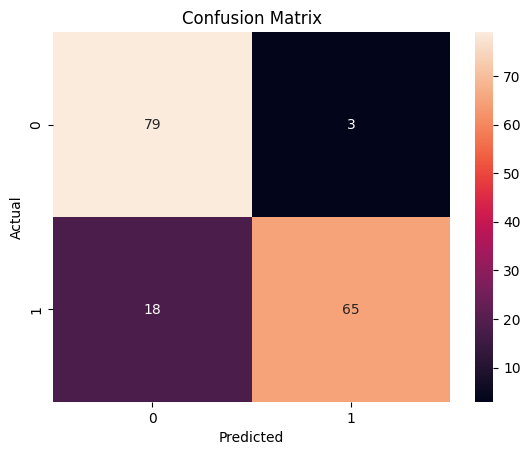

In [45]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

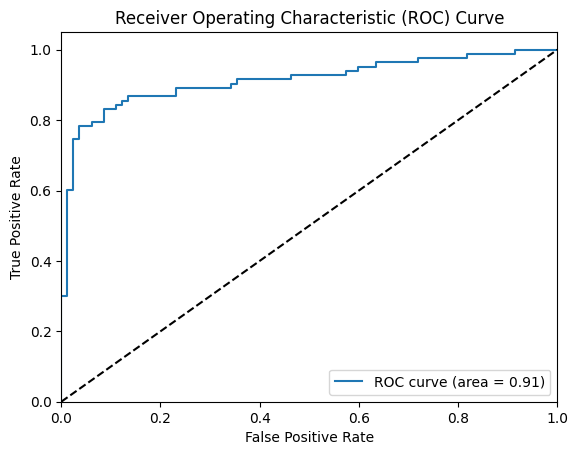

In [46]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test.values.ravel(), y_pred_prob.ravel())
roc_auc = auc(fpr,tpr)

plt.figure()
plt.plot(fpr,tpr,label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0.0 ,1.0])
plt.ylim([0.0 ,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Conclusion

In [7]:
#Data balancing made a big change in the values of accuracy,precision,recall and F1 score.
#Feature selction is very important to consider because there are some irrelavant features like ticket,cabin.Also hyperparameter tuning in important in neural network.

In [2]:
# Here are some complex deep learning architectures that are particularly effective for text data

# 1. Recurrent Neural Networks (RNNs)
# 2. Long Short-Term Memory Networks (LSTMs)
# 3. Gated Recurrent Units (GRUs)
# 4. Transformers